In [1]:
import pandas as pd
import pickle
import re
from collections import defaultdict
%matplotlib inline

In [2]:
df = pd.read_pickle("../../pickles/dataframe_survey_2018-01-23_cleaned.pickle")

# Carl Jungs functions and attitudes

In [3]:
funcs = {
    "t":["ESTJ","ENTJ","ISTP","INTP"],
    "f":["ESFJ","ENFJ","ISFP","INFP"],
    "n":["ENTP","ENFP","INTJ","INFJ"],
    "s":["ESTP","ESFP","ISTJ","ISFJ"]
}

atts = {
    "e":["ESTJ","ENTJ","ESFJ","ENFJ","ENTP","ENFP","ESTP","ESFP"],
    "i":["ISTP","INTP","ISFP","INFP","INTJ","INFJ","ISTJ","ISFJ"]
}

funcatts = {
    "te":["ESTJ","ENTJ"],
    "ti":["ISTP","INTP"],
    "fe":["ESFJ","ENFJ"],
    "fi":["ISFP","INFP"],
    "ne":["ENTP","ENFP"],
    "ni":["INTJ","INFJ"],
    "se":["ESTP","ESFP"],
    "si":["ISTJ","ISFJ"]
}

In [4]:
funclist = []
attlist = []
funcattlist = []

for ix, row in df.iterrows():
    # functions
    for key in funcs:
        if row["actual"] in funcs[key]:
            funclist.append(key)
    
    # attitudes
    for key in atts:
        if row["actual"] in atts[key]:
            attlist.append(key) 
            
    # functions with attitudes
    for key in funcatts:
        if row["actual"] in funcatts[key]:
            funcattlist.append(key) 

fs = pd.Series(funclist)
df["func"] = fs
ats = pd.Series(attlist)
df["att"] = ats
fas = pd.Series(funcattlist)
df["funcatt"] = fas

# James Pennebakers LIWC 2007

[The Development of LIWC 2007](http://www.liwc.net/LIWC2007LanguageManual.pdf)

[Personality Detection by Analysis of Twitter Profiles, Mehul Smriti Raje, Aakarsh Singh](https://books.google.se/books?id=s9IxDwAAQBAJ&lpg=PA675&ots=KVsRfV0yw4&dq=liwc%20jung&pg=PA670#v=onepage&q=liwc%20jung&f=false)

[The Development of LIWC 2015](https://repositories.lib.utexas.edu/bitstream/handle/2152/31333/LIWC2015_LanguageManual.pdf)

[Such Stuff as Dreams Are Made On; Dream Language, LIWC Norms and Personality Correlates](https://www.researchgate.net/publication/316109197_Such_Stuff_as_Dreams_Are_Made_On_Dream_Language_LIWC_Norms_Personality_Correlates)

In [5]:
cats = pickle.load(open("../../pickles/liwc_2007_cats_dict.pickle","rb"))
words = pickle.load(open("../../pickles/liwc_2007_words_dict.pickle","rb"))
    
cats_names = []
for key in cats.keys():
    cats_names.append(cats[key])

In [6]:
def separate_punctuation_with_whitespace(original_string):
   return re.sub(r"([\w/'+$\s-]+|[^\w/'+$\s-]+)\s*", r"\1 ", original_string) # todo: not perfect - leaves "),"


def liwc_analysis_on_english_string(original_string, words):
    """
    Takes a string and returns word frequencies according to (most of) LIWC 2007.
    
    :param original_string: string representing the input text with no transformations.
    :param words: dictionary containing categories as keys with 0.0 as values plus "WC" = word count.
    :return: dictionary containg LIWC 2007 categories minus the psychological summary variables. 
    """ 
    liwc = dict.fromkeys(cats_names, 0.0)
    punct_token_text = separate_punctuation_with_whitespace(original_string)
    liwc["WC"] = len(punct_token_text.split()) # TODO: implement proper tokenization before word count

    for word in words:
        regex_word = re.sub(r"\*",r"\w+",word) # e.g. 'cousin*' in .dic file transformed into 'cousin\w+'
        word_patt = re.compile(regex_word)
        
        if word_patt.search(original_string):
            matches = word_patt.findall(original_string)
            #print("word: {}".format(word))
            #print("cat numbers: {}".format(words[word]))
            try:
                for cat_no in words[word]:
                    if liwc.get(cats[cat_no]):
                        liwc[cats[cat_no]] += (len(matches) / liwc["WC"])   
                    else:
                        liwc[cats[cat_no]] = (len(matches) / liwc["WC"])
            except TypeError as e:
                print("TypeError with cat_no = {}\n{}".format(cat_no, e))
    
    return liwc

In [7]:
# Prepare storage for LIWC-results per row
liwcresults = defaultdict(list)
liwcresults["WC"] = [] # Remeber to store the word count separately, since it's not in LIWC categories
for cat in cats_names:
    liwcresults[cat] = []

In [8]:
# Warning, takes time on an 1,8 GHz Intel Core i5 with 8GB memory
for ix, row in df.iterrows():
    liwc = liwc_analysis_on_english_string(row["text"], words)
    for cat in cats_names:
        liwcresults[cat].append(liwc[cat])
    liwcresults["WC"].append(liwc["WC"])
    print("row: {} WC: {}".format(ix, liwc["WC"]), end="\r")

# Add LIWC-results from memory storage as Pandas Series objects to DataFrame
for cat in cats_names:
    s = pd.Series(liwcresults[cat])
    df[cat] = s

print("Finished counting LIWC words!")

Finished counting LIWC words!


In [9]:
df.head(3)

,url,typealyzer,actual,e,s,t,sntf_s,sntf_n,sntf_t,sntf_f,...,verb,past,present,humans,body,space,anx,sad,negemo,friend
0,http://jonkagstrom.com,ISTP,INFJ,0.420758,0.651605,0.652214,0.512359,0.274234,0.134025,0.079382,...,0.190558,0.032685,0.125614,0.014954,0.028626,0.200598,0.001923,0.003632,0.020295,0.000427
1,http://adropofcolour.tumblr.com,ISFP,INFJ,0.291281,0.787844,0.460961,0.663515,0.178565,0.069282,0.088638,...,0.180068,0.019253,0.123443,0.014723,0.015855,0.134768,0.002265,0.001133,0.020385,0.003398
2,http://godheadcomplex.tumblr.com,ESFP,INFP,0.883579,0.951693,0.238407,0.855921,0.046931,0.021850,0.075297,...,0.206897,0.029557,0.147783,0.024631,0.019704,0.147783,0.000000,0.000000,0.024631,0.000000


In [10]:
df.columns

Index(['url', 'typealyzer', 'actual', 'e', 's', 't', 'sntf_s', 'sntf_n',
       'sntf_t', 'sntf_f', 'date', 'text', 'domains', 'domain', 'func', 'att',
       'funcatt', 'swear', 'quant', 'time', 'inhib', 'ppron', 'home', 'shehe',
       'bio', 'money', 'incl', 'feel', 'hear', 'certain', 'leisure', 'filler',
       'anger', 'ipron', 'excl', 'assent', 'discrep', 'number', 'funct',
       'adverb', 'auxverb', 'posemo', 'i', 'pronoun', 'social', 'you', 'preps',
       'conj', 'they', 'motion', 'article', 'percept', 'nonfl', 'relig',
       'insight', 'we', 'affect', 'family', 'negate', 'relativ', 'sexual',
       'health', 'future', 'cause', 'death', 'tentat', 'cogmech', 'work',
       'see', 'achieve', 'ingest', 'verb', 'past', 'present', 'humans', 'body',
       'space', 'anx', 'sad', 'negemo', 'friend'],
      dtype='object')

# Create datetime column

In [11]:
df.date.head(1)

0    20120828 09:08:55
Name: date, dtype: object

In [12]:
df['datetime'] =  pd.to_datetime(df['date'], format='%Y%m%d %H:%M:%S')

# Create 1-hot categorical dummies for Jungian categories

# Attitudes (E, I)

In [13]:
att_cat = df.att.astype("category")
att_dummies = pd.get_dummies(att_cat)
att_dummies = att_dummies.rename({"e":"is_e", "i":"is_i"}, axis="columns")
df = pd.concat([df,att_dummies], axis=1)
att_dummies.head(1)

,is_e,is_i
0,0,1


## Functions (S, N, T, F)

In [14]:
func_cat = df.func.astype("category")
func_dummies = pd.get_dummies(func_cat)
func_dummies = func_dummies.rename({"f":"is_f", 
                                    "n":"is_n", 
                                    "s":"is_s", 
                                    "t":"is_t"}, axis="columns")
df = pd.concat([df,func_dummies], axis=1)
func_dummies.head(1)

,is_f,is_n,is_s,is_t
0,0,1,0,0


## Functions with attitudes (Si, Se, Ni, Ne, Ti, Te, Fi, Fe )

In [15]:
funcatt_cat = df.funcatt.astype("category")
funcatt_dummies = pd.get_dummies(funcatt_cat)
funcatt_dummies = funcatt_dummies.rename({"fe":"is_fe", 
                                          "fi":"is_fi",
                                          "ne":"is_ne",
                                          "ni":"is_ni",
                                          "se":"is_se",
                                          "si":"is_si",
                                          "te":"is_te",
                                          "ti":"is_ti"
                                            }, axis="columns")
df = pd.concat([df,funcatt_dummies], axis=1)
funcatt_dummies.head(1)

,is_fe,is_fi,is_ne,is_ni,is_se,is_si,is_te,is_ti
0,0,0,0,1,0,0,0,0


# Jung-Meyers types (ENTJ, ISFP etc.)

In [16]:
type_cat = df.actual.astype("category")
type_dummies = pd.get_dummies(type_cat)
type_dummies = type_dummies.rename({"INFJ":"is_infj", 
                                    "INFP":"is_infp",
                                    "INTP":"is_intp",
                                    "ENFJ":"is_enfj",
                                    "ENFP":"is_enfp",
                                    "INTJ":"is_intj",
                                    "ENTP":"is_entp",
                                    "ISTJ":"is_istj",
                                    "ISFJ":"is_isfj",
                                    "ESFP":"is_esfp",
                                    "ISFP":"is_isfp",
                                    "ISTP":"is_istp",
                                    "ENTJ":"is_entj",
                                    "ESFJ":"is_esfj",
                                    "ESTJ":"is_estj",
                                    "ESTP":"is_estp",
                                    "I don't know":"is_unknown"
                                    }, axis="columns")
df = pd.concat([df,type_dummies], axis=1)
type_dummies.head(1)

,is_enfj,is_enfp,is_entj,is_entp,is_esfj,is_esfp,is_estj,is_estp,is_unknown,is_infj,is_infp,is_intj,is_intp,is_isfj,is_isfp,is_istj,is_istp
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### Simple tokenization and word count for each text

In [17]:
lens = []
for index, text in df.text.iteritems():
    lens.append(len(text.split()))
df["tokens"] = pd.Series(lens)

quants = pd.qcut(df.tokens, 5)

In [18]:
quants.value_counts(sort=False)

(-0.001, 118.0]     5596
(118.0, 282.0]      5614
(282.0, 445.0]      5588
(445.0, 740.0]      5571
(740.0, 32016.0]    5590
Name: tokens, dtype: int64

### Store enriched DataFrame to pickle and semicolon-separated CSV

In [19]:
df.to_pickle("../../pickles/dataframe_survey_2018-01-23_enriched.pickle")
df.to_csv("../../data/processed/dataframe_survey_2018-01-23_enriched.csv",sep=";")
print("Finished storing data.")

Finished storing data.


### Find a reasonable threshold for number of tokens for training classifier

In [20]:
mt100_df = df[df["tokens"] > 100]

In [21]:
mt100_df.funcatt.value_counts()

ni    7250
fi    5196
ti    4114
ne    2093
si    1928
fe     743
se     573
te     502
Name: funcatt, dtype: int64

In [22]:
df.head(2)

,url,typealyzer,actual,e,s,t,sntf_s,sntf_n,sntf_t,sntf_f,...,is_unknown,is_infj,is_infp,is_intj,is_intp,is_isfj,is_isfp,is_istj,is_istp,tokens
0,http://jonkagstrom.com,ISTP,INFJ,0.420758,0.651605,0.652214,0.512359,0.274234,0.134025,0.079382,...,0,1,0,0,0,0,0,0,0,3908
1,http://adropofcolour.tumblr.com,ISFP,INFJ,0.291281,0.787844,0.460961,0.663515,0.178565,0.069282,0.088638,...,0,1,0,0,0,0,0,0,0,714


In [24]:
for col in df.columns:
    print(col)

url
typealyzer
actual
e
s
t
sntf_s
sntf_n
sntf_t
sntf_f
date
text
domains
domain
func
att
funcatt
swear
quant
time
inhib
ppron
home
shehe
bio
money
incl
feel
hear
certain
leisure
filler
anger
ipron
excl
assent
discrep
number
funct
adverb
auxverb
posemo
i
pronoun
social
you
preps
conj
they
motion
article
percept
nonfl
relig
insight
we
affect
family
negate
relativ
sexual
health
future
cause
death
tentat
cogmech
work
see
achieve
ingest
verb
past
present
humans
body
space
anx
sad
negemo
friend
datetime
is_e
is_i
is_f
is_n
is_s
is_t
is_fe
is_fi
is_ne
is_ni
is_se
is_si
is_te
is_ti
is_enfj
is_enfp
is_entj
is_entp
is_esfj
is_esfp
is_estj
is_estp
is_unknown
is_infj
is_infp
is_intj
is_intp
is_isfj
is_isfp
is_istj
is_istp
tokens


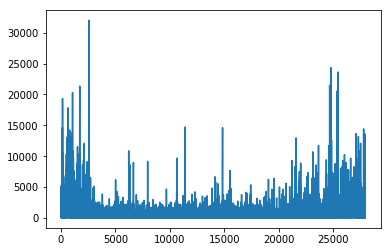

In [30]:
df.tokens.plot()